# Frauds Prediction

In [ ]:
By: Gal Hever

### Exploratory Data Analysis (EDA)

In order to understand the data, it is common to begin with descriptive statistics analysis before the pre-processing section and model building

In [523]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline
plt.rcParams.update({'font.size': 20, 'figure.figsize':(8, 8)})

In [524]:
df = pd.read_csv('ds_interview_dataset.csv')

C:\Users\user\Anaconda3\envs\cs231n\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [493]:
df.head()

,order_id,status,email_anoni,billing_country_code,shipping_country_code,shipping_method,created_at,total_spent,currency_code,gateway,...,V2_distance,V3_distance,V4_our_age,V5_merchant_age,V6_avs_result,V7_bill_ship_name_match,V8_ip,V9_cookie,V10_cookie,V11_cookie
0,176079577,approved,shRbsUOPGM@qq.com,CA,CA,value_1620,2017-04-06,758.471274,CAD,value_100,...,NaN,NaN,618.0,1.0,Unsupported,FL,0.0,0.0,3.767404,NaN
1,201560820,approved,hEjasTK8Vpq6sR@gmail.com,IT,IT,value_1639,2017-06-16,48.319175,EUR,value_169,...,2.0,2.0,0.0,0.0,Missing,FL,0.0,0.0,0.464798,NaN
2,164072492,approved,KOWpxkDYDF@gmail.com,BE,BE,value_244,2017-03-01,1123.094534,EUR,value_151,...,107.0,92.0,1149.0,1437.0,Missing,FL,0.0,1.0,1.258080,0.038704
3,174595495,approved,hKOMNS3@me.com,CH,CH,value_1879,2017-04-02,12.530000,USD,value_247,...,1.0,1.0,169.0,72.0,Missing,FL,0.0,10.0,0.481779,0.008171
4,213517818,approved,PrP6SYm5Q5nMs1tj@hotmail.com,HK,HK,value_291,2017-07-11,480.000000,USD,value_148,...,1.0,1.0,806.0,519.0,Unsupported,FL,0.0,211.0,1.475766,96.343843


General information

In [494]:
df.shape

(190000, 21)

In [495]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190000 entries, 0 to 189999
Data columns (total 21 columns):
order_id                   190000 non-null int64
status                     190000 non-null object
email_anoni                190000 non-null object
billing_country_code       189223 non-null object
shipping_country_code      189721 non-null object
shipping_method            185461 non-null object
created_at                 190000 non-null object
total_spent                190000 non-null float64
currency_code              190000 non-null object
gateway                    189862 non-null object
V1_link                    189993 non-null object
V2_distance                157964 non-null float64
V3_distance                158957 non-null float64
V4_our_age                 189993 non-null float64
V5_merchant_age            189993 non-null float64
V6_avs_result              189993 non-null object
V7_bill_ship_name_match    189993 non-null object
V8_ip                      185132 n

In [496]:
# Percentages of missing values
df.isnull().sum().sum()
df.isnull().sum()/len(df)*100

order_id                    0.000000
status                      0.000000
email_anoni                 0.000000
billing_country_code        0.408947
shipping_country_code       0.146842
shipping_method             2.388947
created_at                  0.000000
total_spent                 0.000000
currency_code               0.000000
gateway                     0.072632
V1_link                     0.003684
V2_distance                16.861053
V3_distance                16.338421
V4_our_age                  0.003684
V5_merchant_age             0.003684
V6_avs_result               0.003684
V7_bill_ship_name_match     0.003684
V8_ip                       2.562105
V9_cookie                   0.096842
V10_cookie                  0.974737
V11_cookie                 41.423684
dtype: float64

In [497]:
df.nunique()

order_id                   189041
status                          3
email_anoni                189946
billing_country_code          213
shipping_country_code         195
shipping_method              2367
created_at                    519
total_spent                 89925
currency_code                  35
gateway                       255
V1_link                         2
V2_distance                 10530
V3_distance                 10707
V4_our_age                   6324
V5_merchant_age              2920
V6_avs_result                   7
V7_bill_ship_name_match         4
V8_ip                         160
V9_cookie                    2995
V10_cookie                  45978
V11_cookie                  79870
dtype: int64

"order_id" and "email_anoni" features have too many unique values, I would have recommended to add the fraudulent email addresses to some black list and to work with NLP for identifing new fraudulent addresses. 

C:\Users\user\Anaconda3\envs\cs231n\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


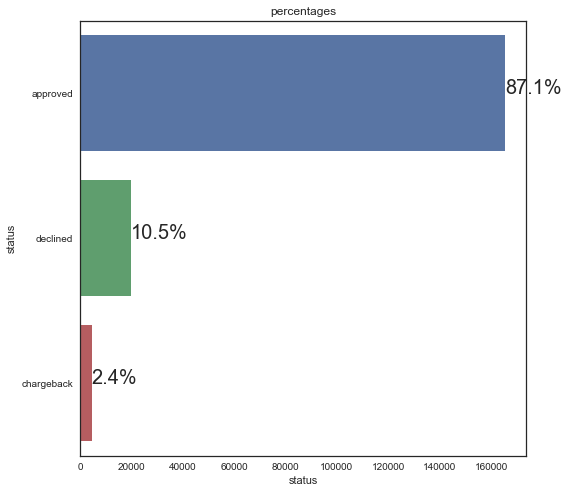

In [498]:
col = "status"
ax = sns.countplot(y="status", data=df)
plt.title("percentages")
plt.xlabel('status')

total = len(df[col])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

In [499]:
df.groupby(['status'])['status'].count()

status
approved      165441
chargeback      4559
declined       20000
Name: status, dtype: int64

#### Adding new features

In [525]:
df["address_difference"] = df.apply(lambda x: True if (x['shipping_country_code']==x['billing_country_code'])&(pd.notnull(x['billing_country_code'])&pd.notnull(x['shipping_country_code'])) else False, axis=1)

In [526]:
df['created_at']=pd.to_datetime(df['created_at'])
df['weekday'] = df['created_at'].dt.dayofweek
df['month'] = df['created_at'].dt.month

Setting data types

In [527]:
categories = ['order_id','email_anoni','billing_country_code','shipping_country_code','shipping_method','currency_code','gateway','V1_link','V6_avs_result','V7_bill_ship_name_match','address_difference', 'weekday', 'month']
for col in categories:
    df[col] = df[col].astype('category')

In [528]:
all_col = df.columns
num_columns = df._get_numeric_data().columns
#cat_columns = all_col.drop(num_columns)

#### Investigation of missing values and their connection to fraudulent transactions

In [529]:
d = pd.DataFrame(df.loc[pd.isnull(df['V2_distance'])==True,:].groupby(['status'])['status'].count())
d['percent'] = (d['status']/d['status'].sum())*100
d

,status,percent
status,,
approved,27044,84.417530
chargeback,690,2.153827
declined,4302,13.428643


In [377]:
d = pd.DataFrame(df.loc[pd.isnull(df['V2_distance'])==False,:].groupby(['status'])['status'].count())
d['percent'] = (d['status']/d['status'].sum())*100
d

,status,percent
status,,
approved,138397,87.613000
chargeback,3869,2.449292
declined,15698,9.937707


In [378]:
d = pd.DataFrame(df.loc[pd.isnull(df['V11_cookie'])==True,:].groupby(['status'])['status'].count())
d['percent'] = (d['status']/d['status'].sum())*100
d

,status,percent
status,,
approved,68454,86.975415
chargeback,1187,1.508163
declined,9064,11.516422


In [379]:
d = pd.DataFrame(df.loc[pd.isnull(df['V11_cookie'])==False,:].groupby(['status'])['status'].count())
d['percent'] = (d['status']/d['status'].sum())*100
d

,status,percent
status,,
approved,96987,87.144077
chargeback,3372,3.029786
declined,10936,9.826138


No direct connection was founded between the missingness and the fraudulent transactions.

#### Descriptive statistics

In [380]:
# Check for duplicated rows
df.duplicated().sum().sum()

0

In [42]:
def describe(df):
    return pd.concat([df.describe().T,
                      df.mad().rename('mad'),
                      df.skew().rename('skew'),
                      df.kurt().rename('kurt'),
                     ], axis=1).T

In [43]:
describe(df[num_columns])

,total_spent,V2_distance,V3_distance,V4_our_age,V5_merchant_age,V8_ip,V9_cookie,V10_cookie,V11_cookie
count,190000.000000,157964.000000,158957.000000,189993.000000,189993.000000,185132.000000,189816.000000,188148.000000,111295.000000
mean,262.806693,1176.859443,1262.328208,653.947451,216.220645,0.076579,82.207796,5.305185,47.386270
std,497.157831,3088.102927,3206.620899,2046.051781,6976.480661,0.387298,589.419776,9.227724,114.170882
min,0.000000,0.000000,0.000000,0.000000,-323.000000,0.000000,0.000000,0.000000,-140.884769
25%,77.400000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.631284,0.016134
50%,140.400000,13.000000,13.000000,51.000000,1.000000,0.000000,4.000000,1.533317,1.773900
75%,267.000000,174.000000,198.000000,692.000000,82.000000,0.000000,18.000000,4.443918,36.878183
max,57746.005396,19610.000000,19610.000000,730603.000000,736666.000000,4.000000,24260.000000,100.000000,1181.605035
mad,222.562151,1867.092519,1989.306786,828.644485,327.305372,0.146697,131.461567,5.884010,64.709058
skew,21.731594,2.893895,2.759254,239.454564,105.240127,5.321033,17.067594,3.028866,4.201627


In [44]:
df.select_dtypes(include='category').describe()

,order_id,status,email_anoni,billing_country_code,shipping_country_code,shipping_method,currency_code,gateway,V1_link,V6_avs_result,V7_bill_ship_name_match,address_difference,weekday,month
count,190000,190000,190000,189223,189721,185461,190000,189862,189993,189993,189993,190000,190000,190000
unique,189041,3,189946,213,195,2367,35,255,2,7,4,2,7,12
top,171520821,approved,NA@personal_domain.com,US,US,value_1645,USD,value_65,False,Unsupported,FL,True,3,11
freq,3,165441,30,65900,71482,20896,124681,28344,188851,68569,167300,178653,31407,25736


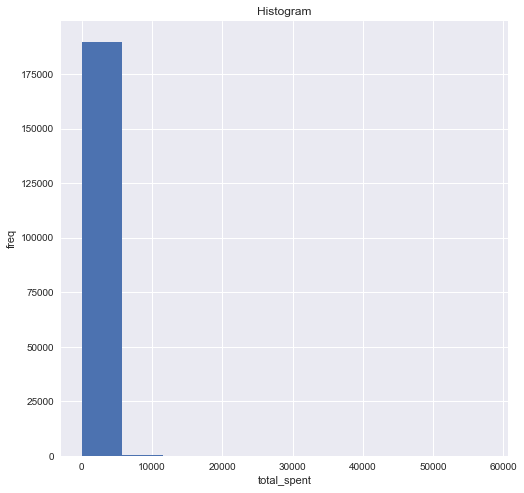

C:\Users\user\Anaconda3\envs\cs231n\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\user\Anaconda3\envs\cs231n\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


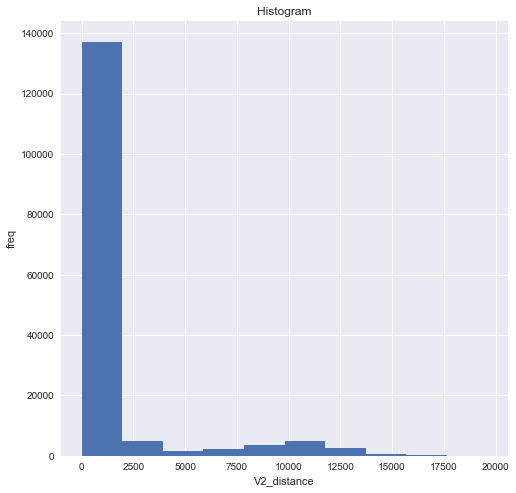

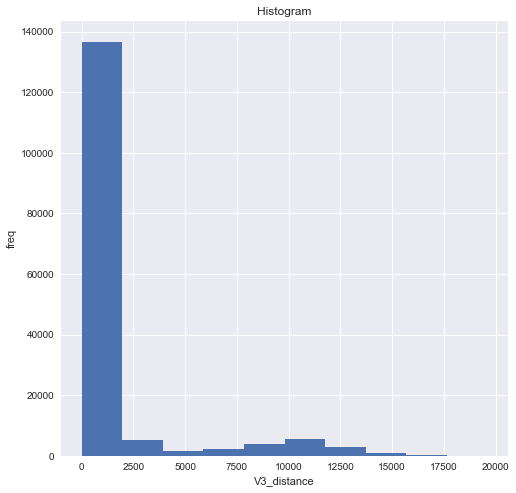

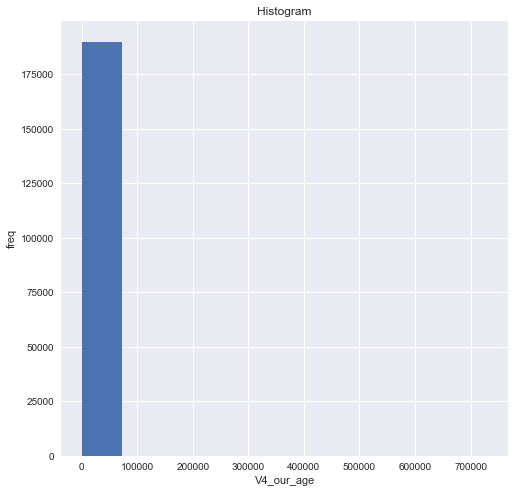

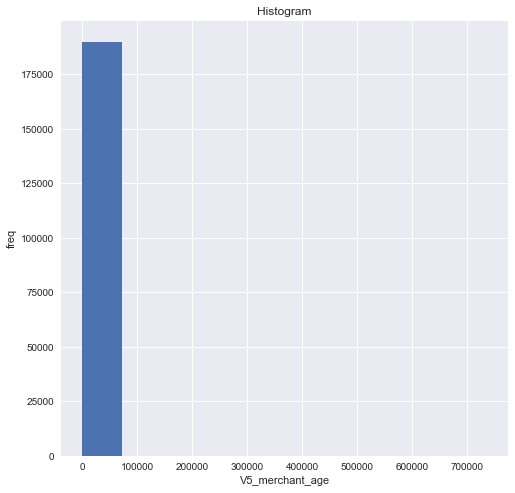

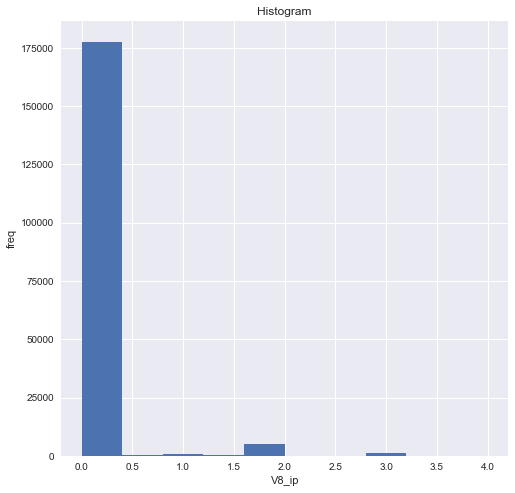

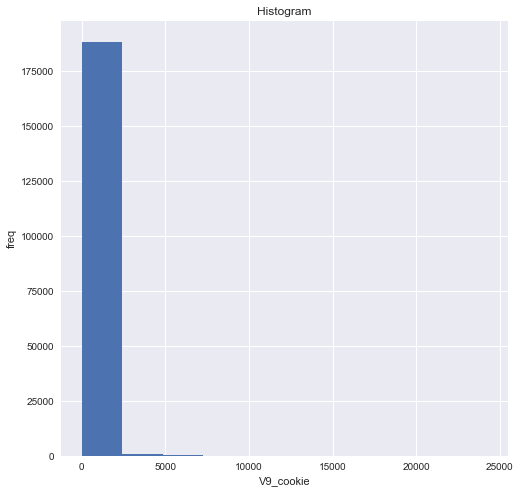

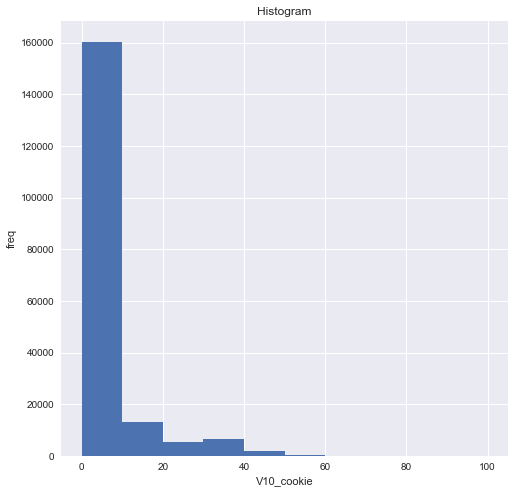

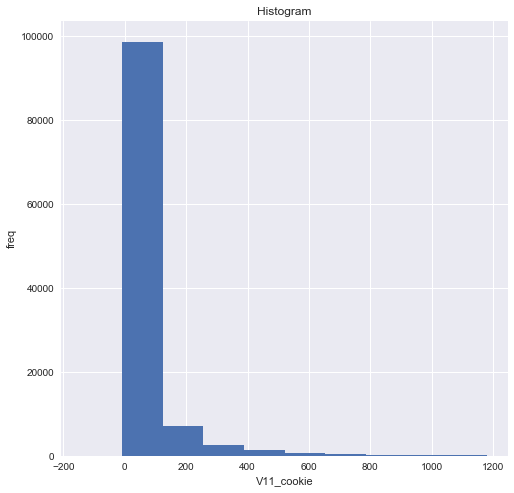

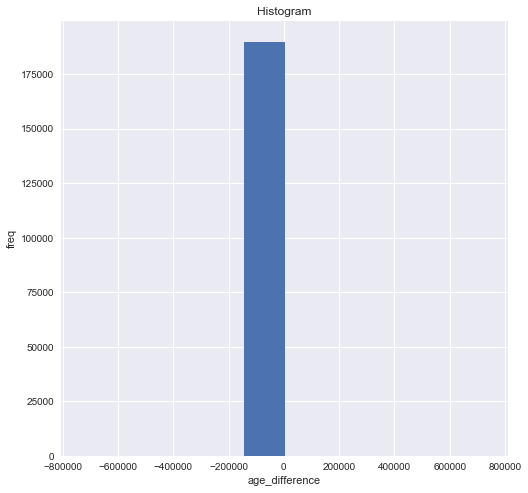

In [1264]:
for col in num_columns:
    col_data = df[col]
    plt.hist(col_data)
    plt.xlabel(col)
    plt.ylabel('freq')
    plt.title('Histogram')
    plt.grid(True)
    plt.show()

C:\Users\user\Anaconda3\envs\cs231n\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


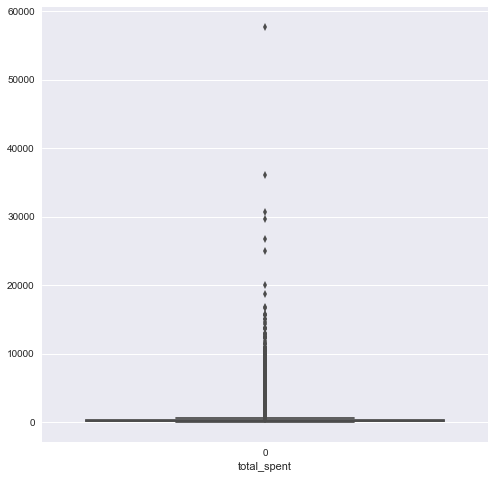

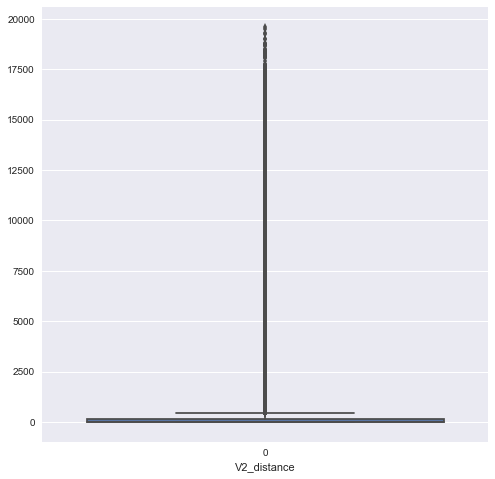

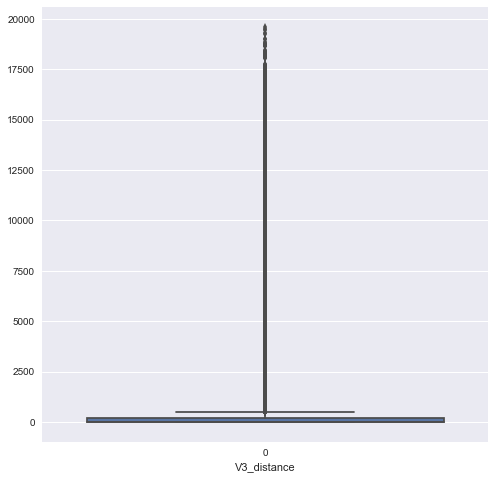

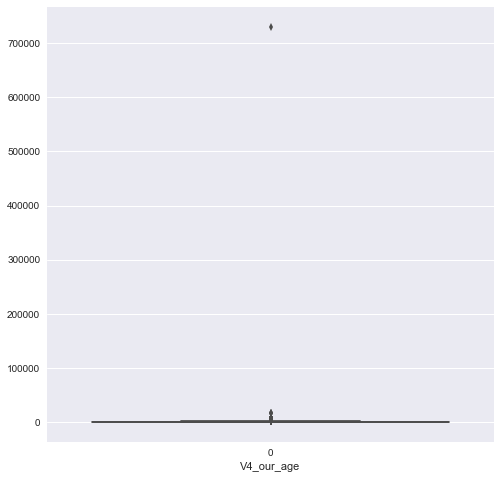

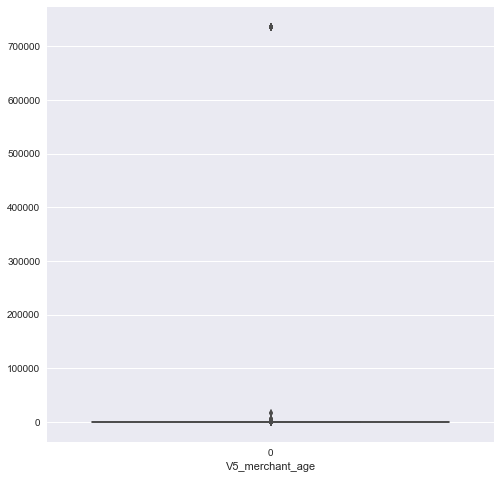

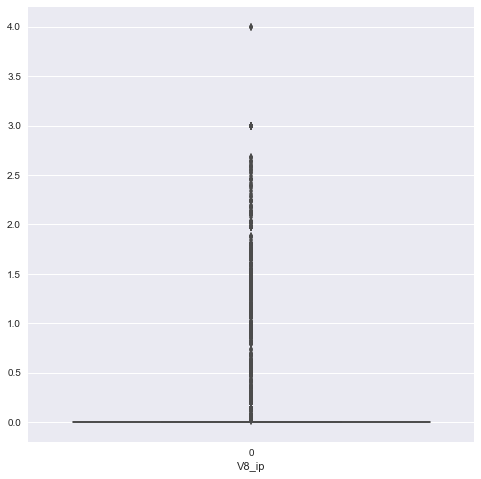

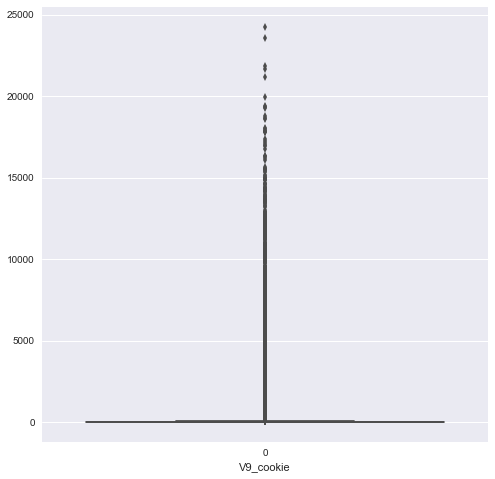

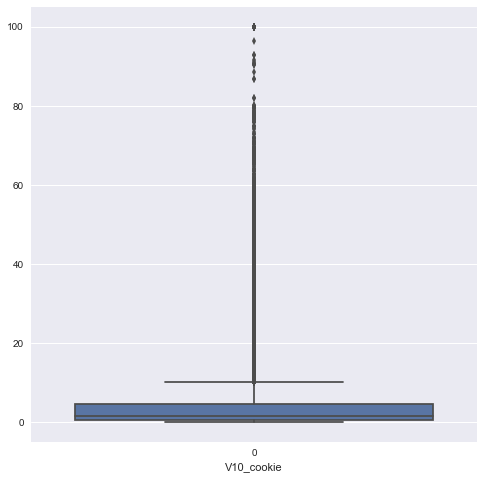

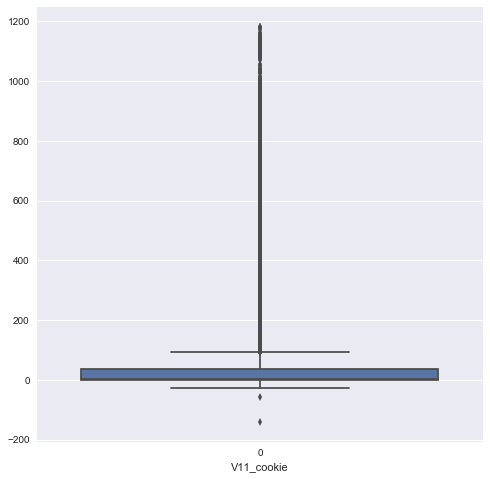

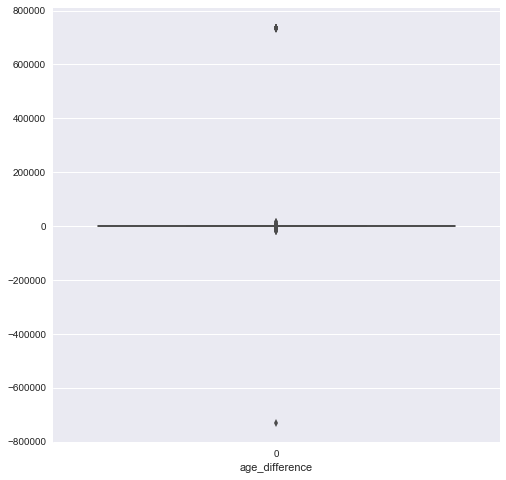

In [1265]:
# Boxplot
for col in num_columns:
    sns.boxplot(data=df[col])
    plt.xlabel(col)
    fig=plt.gcf()
    fig.set_size_inches(8,8)
    plt.show()

C:\Users\user\Anaconda3\envs\cs231n\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


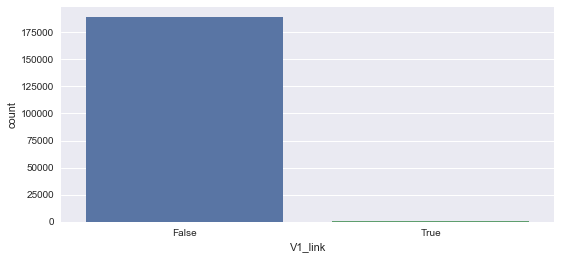

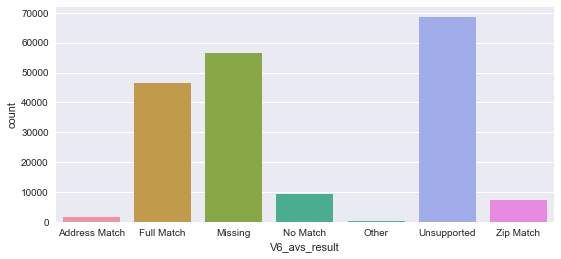

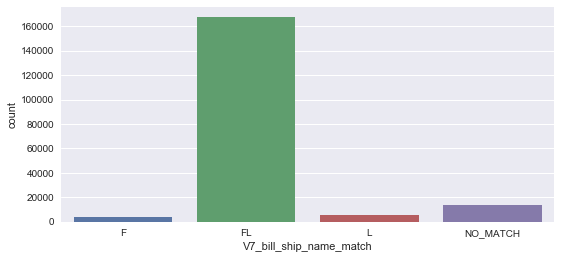

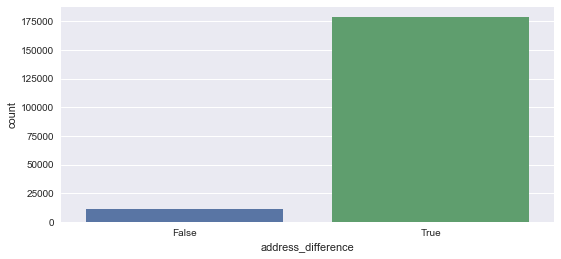

In [1266]:
# Bar graphs - for categorical features
cats = ['V1_link', 'V6_avs_result', 'V7_bill_ship_name_match', 'address_difference']
for col in cats:
    sns.factorplot(data=df, x=col, kind= 'count',size=4,aspect=2)
    plt.show()

C:\Users\user\Anaconda3\envs\cs231n\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


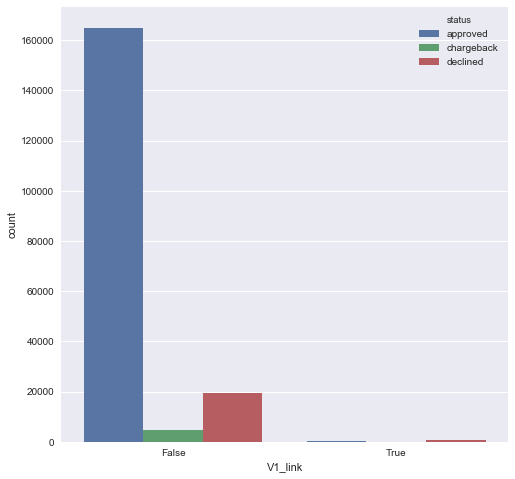

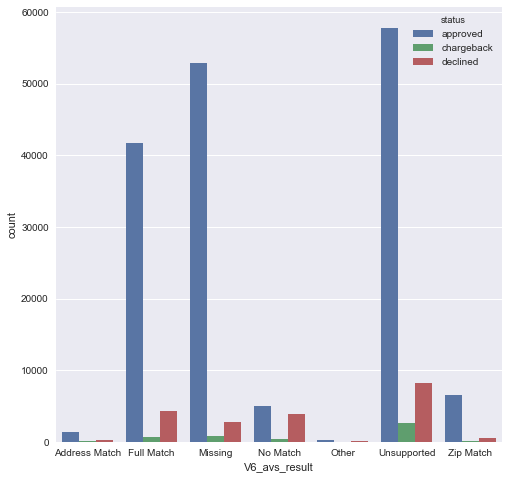

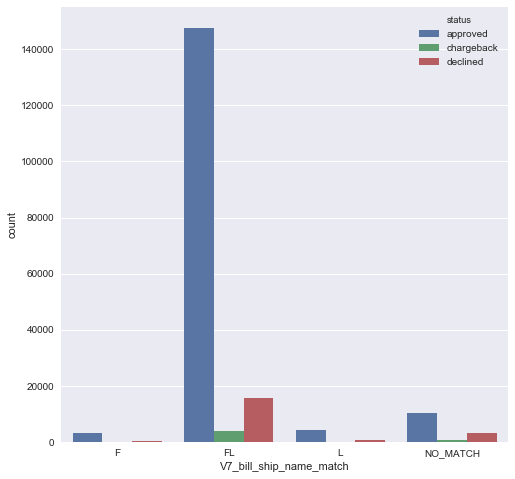

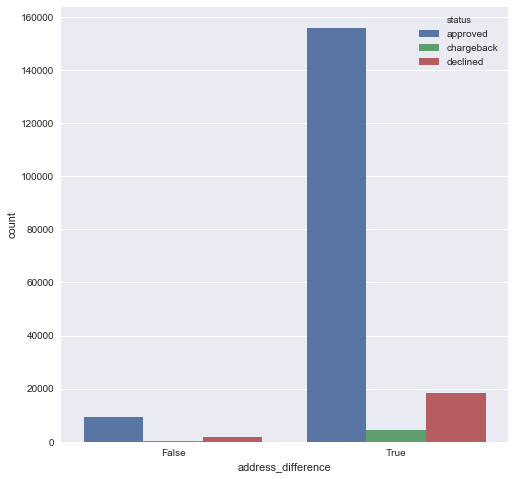

In [1267]:
for col in cats:
    sns.countplot(x=col, hue='status', data=df)
    plt.show()

#### Features are grouped by status

In [1268]:
pd.DataFrame(df.groupby('status')['total_spent'].describe())

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
approved,165441.0,238.852496,459.273347,0.0,75.2500,133.930000,233.780000,57746.005396
chargeback,4559.0,473.475401,753.094543,0.0,155.0000,271.574499,563.817123,14971.660552
declined,20000.0,412.935083,660.757490,0.0,119.5225,230.565000,491.426752,36008.500000


In [1269]:
pd.DataFrame(df.groupby('status')['V1_link'].describe())

,count,unique,top,freq
status,,,,
approved,165438,2,False,164964
chargeback,4558,2,False,4527
declined,19997,2,False,19360


In [6]:
perc = df.groupby(['V1_link', 'status']).agg({'status': 'count'})
perc2 = perc.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
perc3 = perc2.add_suffix('_perc').reset_index()
perc3[(perc3['status_perc']==100)&(perc3['status'].isin(['declined', 'chargeback']))]

,V1_link,status,status_perc


In [10]:
perc2

status
V1_link status               
False   approved    87.351404
        chargeback   2.397128
        declined    10.251468
True    approved    41.506130
        chargeback   2.714536
        declined    55.779335

In [ ]:
perc = df[df['status'].isin('declined','chargeback')].groupby(['V1_link', 'status']).agg({'status_perc': 'sum'})
perc2 = perc.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
perc3 = perc2.add_suffix('_perc').reset_index()
perc3[(perc3['status_perc']==100)&(perc3['status'].isin(['declined', 'chargeback']))]

In [1271]:
pd.DataFrame(df.groupby('status')['V2_distance'].describe())

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
approved,138397.0,1026.969190,2923.363953,0.0,4.0,12.0,102.0,19610.0
chargeback,3869.0,1182.608684,3096.429041,0.0,5.0,15.0,221.0,18516.0
declined,15698.0,2496.907695,4039.253429,0.0,9.0,312.0,2793.0,18719.0


In [1272]:
pd.DataFrame(df.groupby('status')['V4_our_age'].describe())

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
approved,165438.0,653.083143,2143.593742,0.0,0.0,60.0,691.00,730603.0
chargeback,4558.0,801.660377,1223.094812,0.0,0.0,89.5,1230.75,17158.0
declined,19997.0,627.429164,1188.732213,0.0,0.0,13.0,571.00,17245.0


In [126]:
pd.DataFrame(df.groupby('status')['V5_merchant_age'].describe())

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
approved,165438.0,243.197566,7475.619831,-323.0,0.0,1.0,114.0,736666.0
chargeback,4558.0,59.256033,227.349084,-264.0,0.0,0.0,2.0,3302.0
declined,19997.0,28.814372,166.581569,-264.0,0.0,1.0,1.0,3238.0


In [334]:
pd.DataFrame(df.groupby('status')['address_difference'].describe())

,count,unique,top,freq
status,,,,
approved,165441,2,True,155925
chargeback,4559,2,True,4357
declined,20000,2,True,18371


In [338]:
perc = df.groupby(['address_difference', 'status']).agg({'status': 'count'})
perc2 = perc.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
perc3 = perc2.add_suffix('_perc').reset_index()
perc3

,address_difference,status,status_perc
0,False,approved,83.863576
1,False,chargeback,1.780206
2,False,declined,14.356218
3,True,approved,87.278131
4,True,chargeback,2.438806
5,True,declined,10.283063


In [127]:
pd.DataFrame(df.groupby('status')['V6_avs_result'].describe())

,count,unique,top,freq
status,,,,
approved,165438,7,Unsupported,57810
chargeback,4558,7,Unsupported,2574
declined,19997,7,Unsupported,8185


In [11]:
perc = df.groupby(['V6_avs_result', 'status']).agg({'status': 'count'})
perc2 = perc.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
perc3 = perc2.add_suffix('_perc').reset_index()
perc3[(perc3['status_perc']==100)&(perc3['status'].isin(['declined', 'chargeback']))]

,V6_avs_result,status,status_perc


In [12]:
perc2

status
V6_avs_result status               
Address Match approved    84.328358
              chargeback   2.985075
              declined    12.686567
Full Match    approved    89.424686
              chargeback   1.398601
              declined     9.176713
Missing       approved    93.606464
              chargeback   1.463709
              declined     4.929827
No Match      approved    54.435878
              chargeback   3.616028
              declined    41.948094
Other         approved    73.638968
              chargeback   2.005731
              declined    24.355301
Unsupported   approved    84.309236
              chargeback   3.753883
              declined    11.936881
Zip Match     approved    90.038846
              chargeback   1.637070
              declined     8.324084

In [388]:
pd.DataFrame(df.groupby('status')['V7_bill_ship_name_match'].describe())

,count,unique,top,freq
status,,,,
approved,165438,4,FL,147755
chargeback,4558,4,FL,3962
declined,19997,4,FL,15583


In [13]:
perc = df.groupby(['V7_bill_ship_name_match', 'status']).agg({'status': 'count'})
perc2 = perc.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
perc3 = perc2.add_suffix('_perc').reset_index()
perc3[(perc3['status_perc']==100)&(perc3['status'].isin(['declined', 'chargeback']))]

,V7_bill_ship_name_match,status,status_perc


In [14]:
perc2

status
V7_bill_ship_name_match status               
F                       approved    87.527778
                        chargeback   0.944444
                        declined    11.527778
FL                      approved    88.317394
                        chargeback   2.368201
                        declined     9.314405
L                       approved    83.687390
                        chargeback   1.559150
                        declined    14.753459
NO_MATCH                approved    73.327603
                        chargeback   3.452227
                        declined    23.220169

In [390]:
pd.DataFrame(df.groupby('status')['V8_ip'].describe())

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
approved,161147.0,0.028921,0.231741,0.0,0.0,0.0,0.0,3.0
chargeback,4484.0,0.071215,0.366775,0.0,0.0,0.0,0.0,3.0
declined,19501.0,0.471633,0.880057,0.0,0.0,0.0,0.0,4.0


In [391]:
pd.DataFrame(df.groupby('status')['V9_cookie'].describe())

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
approved,165339.0,81.792318,591.266794,0.0,0.0,4.0,19.0,24260.0
chargeback,4545.0,74.655006,650.973667,0.0,0.0,2.0,11.0,15548.0
declined,19932.0,87.376480,558.490753,0.0,0.0,2.0,14.0,12608.0


In [392]:
pd.DataFrame(df.groupby('status')['V10_cookie'].describe())

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
approved,164074.0,4.407578,7.905817,0.0,0.600801,1.411881,3.762988,100.00000
chargeback,4427.0,13.729512,14.057750,0.0,1.299116,7.992558,29.973034,79.62963
declined,19647.0,10.902953,13.961234,0.0,1.258951,4.500818,14.384616,100.00000


In [393]:
pd.DataFrame(df.groupby('status')['V11_cookie'].describe())

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
approved,96987.0,52.028068,120.195771,-140.884769,0.019560,2.536412,43.604342,1181.605035
chargeback,3372.0,13.169760,48.507363,-1.809178,0.006897,0.015141,1.762564,1075.740822
declined,10936.0,16.770325,48.135910,-3.473229,0.008576,0.100969,9.216131,791.807373


In [394]:
pd.DataFrame(df.groupby('status')['billing_country_code'].describe())

,count,unique,top,freq
status,,,,
approved,164752,205,US,53558
chargeback,4552,84,US,1157
declined,19919,142,US,11185


In [15]:
perc = df.groupby(['billing_country_code', 'status']).agg({'status': 'count'})
perc2 = perc.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
perc3 = perc2.add_suffix('_perc').reset_index()
perc3[(perc3['status_perc']==100)&(perc3['status'].isin(['declined', 'chargeback']))]

,billing_country_code,status,status_perc
47,BF,declined,100.0
142,FX,declined,100.0
198,IR,declined,100.0
267,ML,declined,100.0
383,TN,declined,100.0
423,XK,declined,100.0
430,ZW,declined,100.0


In [20]:
perc4=perc3[perc3['status'].isin(['declined', 'chargeback'])]
perc5=perc4.groupby(['billing_country_code']).agg({'status_perc': 'sum'})
perc5[(perc5['status_perc']==100)] 

,status_perc
billing_country_code,
BF,100.0
DZ,100.0
FX,100.0
IR,100.0
ML,100.0
TN,100.0
XK,100.0
ZW,100.0


In [395]:
pd.DataFrame(df.groupby('status')['shipping_country_code'].describe())

,count,unique,top,freq
status,,,,
approved,165268,186,US,58573
chargeback,4546,76,US,1196
declined,19907,122,US,11713


In [22]:
perc = df.groupby(['shipping_country_code', 'status']).agg({'status': 'count'})
perc2 = perc.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
perc3 = perc2.add_suffix('_perc').reset_index()
perc3[(perc3['status_perc']==100)&(perc3['status'].isin(['declined', 'chargeback']))]

,shipping_country_code,status,status_perc
73,CM,declined,100.0
119,FX,declined,100.0
147,HN,declined,100.0
168,IQ,declined,100.0
290,PM,declined,100.0
340,TN,declined,100.0
377,XK,declined,100.0
383,ZW,declined,100.0


In [23]:
perc4=perc3[perc3['status'].isin(['declined', 'chargeback'])]
perc5=perc4.groupby(['shipping_country_code']).agg({'status_perc': 'sum'})
perc5[(perc5['status_perc']==100)] 

,status_perc
shipping_country_code,
CM,100.0
DZ,100.0
FX,100.0
HN,100.0
IQ,100.0
PM,100.0
TN,100.0
XK,100.0
ZW,100.0


In [314]:
pd.DataFrame(df.groupby('status')['shipping_method'].describe())

,count,unique,top,freq
status,,,,
approved,162230,2079,value_1645,20640
chargeback,3781,310,value_291,448
declined,19450,1033,value_1059,5289


In [318]:
perc = df.groupby(['shipping_method', 'status']).agg({'status': 'count'})
perc2 = perc.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
perc3 = perc2.add_suffix('_perc').reset_index()
full_dec_charged=perc3[(perc3['status_perc']==100)&(perc3['status'].isin(['declined', 'chargeback']))]

In [322]:
perc4=perc3[perc3['status'].isin(['declined', 'chargeback'])]
perc5=perc4.groupby(['shipping_method']).agg({'status_perc': 'sum'})
perc5 = perc5.reset_index()
frauds=perc5[(perc5['status_perc']==100)]

cut = pd.merge(frauds, full_dec_charged, how='inner', on="shipping_method")
frauds[(~frauds['shipping_method'].isin(cut['shipping_method']))]

,shipping_method,status_perc
166,value_1294,100.0
221,value_1414,100.0
324,value_1589,100.0
568,value_2118,100.0
581,value_2134,100.0
599,value_2173,100.0
706,value_25,100.0
805,value_456,100.0
868,value_569,100.0
1019,value_844,100.0


In [456]:
pd.DataFrame(df.groupby('status')['currency_code'].describe())

,count,unique,top,freq
status,,,,
approved,165441,34,USD,106959
chargeback,4559,27,USD,2234
declined,20000,33,USD,15488


In [26]:
perc = df.groupby(['currency_code', 'status']).agg({'status': 'count'})
perc2 = perc.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
perc3 = perc2.add_suffix('_perc').reset_index()
perc3[(perc3['status_perc']==100)&(perc3['status'].isin(['declined', 'chargeback']))]

,currency_code,status,status_perc
47,KES,declined,100.0


In [27]:
perc4=perc3[perc3['status'].isin(['declined', 'chargeback'])]
perc5=perc4.groupby(['currency_code']).agg({'status_perc': 'sum'})
perc5[(perc5['status_perc']==100)] 

,status_perc
currency_code,
KES,100.0


In [30]:
perc = df.groupby(['gateway', 'status']).agg({'status': 'count'})
perc2 = perc.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
perc3 = perc2.add_suffix('_perc').reset_index()
perc3[(perc3['status_perc']==100)&(perc3['status'].isin(['declined', 'chargeback']))]

,gateway,status,status_perc
21,value_106,declined,100.0
80,value_134,declined,100.0
97,value_141,declined,100.0
107,value_146,declined,100.0
108,value_147,declined,100.0
131,value_156,declined,100.0
135,value_159,declined,100.0
150,value_165,declined,100.0
207,value_188,declined,100.0
229,value_199,declined,100.0


In [29]:
perc4=perc3[perc3['status'].isin(['declined', 'chargeback'])]
perc5=perc4.groupby(['gateway']).agg({'status_perc': 'sum'})
perc5[(perc5['status_perc']==100)] 

,status_perc
gateway,
value_106,100.0
value_134,100.0
value_141,100.0
value_146,100.0
value_147,100.0
value_156,100.0
value_159,100.0
value_165,100.0
value_188,100.0


In [1273]:
df.created_at = pd.to_datetime(df.created_at)

In [1274]:
df.created_at.min(), df.created_at.max()

(Timestamp('2015-07-30 00:00:00'), Timestamp('2017-07-18 00:00:00'))

In [1275]:
df.created_at.max()-df.created_at.min()

Timedelta('719 days 00:00:00')

In [537]:
perc = df.groupby(['month', 'status']).agg({'status': 'count'})
perc.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

status
month status               
1     approved    85.688973
      chargeback   2.634221
      declined    11.676806
2     approved    83.948288
      chargeback   2.522711
      declined    13.529001
3     approved    82.314959
      chargeback   3.318187
      declined    14.366854
4     approved    85.486968
      chargeback   4.071331
      declined    10.441701
5     approved    86.487418
      chargeback   2.713350
      declined    10.799232
6     approved    87.397725
      chargeback   2.377148
      declined    10.225127
7     approved    88.127105
      chargeback   1.994646
      declined     9.878249
8     approved    86.119874
      chargeback   4.100946
      declined     9.779180
9     approved    91.387872
      chargeback   2.469942
      declined     6.142185
10    approved    91.856156
      chargeback   1.852788
      declined     6.291056
11    approved    90.744482
      chargeback   1.064657
      declined     8.190861
12    approved    86.526863
      chargeback   1.864480
      declined    11.608656

In [530]:
df['status'] = df['status'].map({'approved':'1','chargeback':'0','declined':'0'})

In [531]:
df['status'] = df['status'].astype('int64')

In [532]:
heat = df.groupby(['shipping_country_code', 'billing_country_code']).agg({'status': 'sum'})

In [533]:
heat2 = heat.add_suffix('_sum').reset_index()

In [534]:
heat3=heat2.pivot_table(index='shipping_country_code', columns='billing_country_code', values='status_sum', aggfunc=np.sum)
#sns.heatmap(heat3,annot=True, fmt=".1f")
#plt.rcParams.update({'font.size': 5, 'figure.figsize':(50, 50)})
#plt.show()

### Dealing with Multicollinearity

#### Correlation Matrix

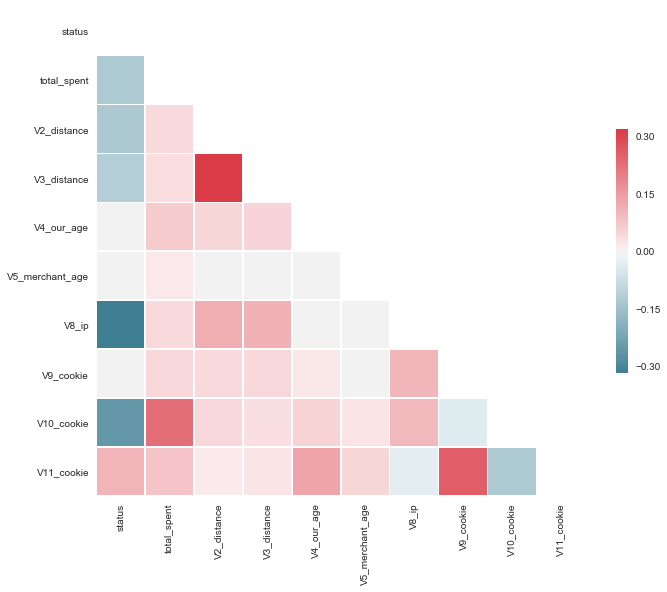

In [535]:
# Compute the correlation matrix for the numeric features
sns.set(style="white")

corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [536]:
df.corr()

,status,total_spent,V2_distance,V3_distance,V4_our_age,V5_merchant_age,V8_ip,V9_cookie,V10_cookie,V11_cookie
status,1.000000,-0.125056,-0.129088,-0.112930,-0.001096,0.010037,-0.318956,-0.001832,-0.253944,0.105852
total_spent,-0.125056,1.000000,0.042038,0.036675,0.066458,0.015846,0.041663,0.043746,0.228724,0.078452
V2_distance,-0.129088,0.042038,1.000000,0.836016,0.049671,0.005155,0.118455,0.039970,0.044467,0.013824
V3_distance,-0.112930,0.036675,0.836016,1.000000,0.052180,0.002498,0.109975,0.044392,0.034327,0.023297
V4_our_age,-0.001096,0.066458,0.049671,0.052180,1.000000,0.007440,-0.009750,0.019174,0.053236,0.136960
V5_merchant_age,0.010037,0.015846,0.005155,0.002498,0.007440,1.000000,-0.002669,0.007346,0.022975,0.049137
V8_ip,-0.318956,0.041663,0.118455,0.109975,-0.009750,-0.002669,1.000000,0.102816,0.099466,-0.031715
V9_cookie,-0.001832,0.043746,0.039970,0.044392,0.019174,0.007346,0.102816,1.000000,-0.037776,0.255656
V10_cookie,-0.253944,0.228724,0.044467,0.034327,0.053236,0.022975,0.099466,-0.037776,1.000000,-0.124429
V11_cookie,0.105852,0.078452,0.013824,0.023297,0.136960,0.049137,-0.031715,0.255656,-0.124429,1.000000


In [537]:
co = corr.unstack()

#### Positive correlation

In [538]:
sort_cor = co.sort_values(kind="quicksort")
pd.DataFrame(sort_cor[sort_cor > 0.8])

,,0
V3_distance,V2_distance,0.836016
V2_distance,V3_distance,0.836016
status,status,1.000000
V9_cookie,V9_cookie,1.000000
V8_ip,V8_ip,1.000000
V5_merchant_age,V5_merchant_age,1.000000
V4_our_age,V4_our_age,1.000000
V3_distance,V3_distance,1.000000
V2_distance,V2_distance,1.000000
total_spent,total_spent,1.000000


There is a high positive correlation between V2 and V3.

#### Negative correlation

In [539]:
sort_cor = co.sort_values(kind="quicksort")
pd.DataFrame(sort_cor[sort_cor < -0.8])

,,0


### Data Smoothing and Outliers Detection

In [540]:
# Check for outliers 
for col in num_columns:
    # Getting 75 and 25 percentile of variable "i"
    q75, q25 = np.percentile(df[col], [75,25])
    
    # Calculating Interquartile range
    iqr = q75 - q25
    
    # Calculating upper extream and lower extream
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    
    # Replacing all the outliers value to NA
    df.loc[df[col]< minimum,col] = np.nan
    df.loc[df[col]> maximum,col] = np.nan

C:\Users\user\Anaconda3\envs\cs231n\lib\site-packages\numpy\lib\function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


### Dealing with missing values

#### Categorial features

In [541]:
from sklearn_pandas import CategoricalImputer
cat_miss=['billing_country_code' , 'shipping_country_code', 'shipping_method', 'gateway', 'V1_link','V6_avs_result','V7_bill_ship_name_match']
# instantiate CategoricalImputer
imputer = CategoricalImputer()
df[cat_miss] = df[cat_miss].apply(lambda x: imputer.fit_transform(x), axis=0)

#### Numerical features

In [542]:
from sklearn.preprocessing import Imputer
# Deal with missing values - strategy can be changed to "median" and “mode”
imp = Imputer(missing_values=np.nan, strategy='mean')
values = df[num_columns].values
df[num_columns] = imp.fit_transform(values)

In [543]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190000 entries, 0 to 189999
Data columns (total 24 columns):
order_id                   190000 non-null category
status                     190000 non-null int64
email_anoni                190000 non-null category
billing_country_code       190000 non-null object
shipping_country_code      190000 non-null object
shipping_method            190000 non-null object
created_at                 190000 non-null datetime64[ns]
total_spent                190000 non-null float64
currency_code              190000 non-null category
gateway                    190000 non-null object
V1_link                    190000 non-null object
V2_distance                190000 non-null float64
V3_distance                190000 non-null float64
V4_our_age                 190000 non-null float64
V5_merchant_age            190000 non-null float64
V6_avs_result              190000 non-null object
V7_bill_ship_name_match    190000 non-null object
V8_ip                

In [544]:
categories = ['billing_country_code','shipping_country_code','shipping_method','currency_code','gateway','V1_link','V6_avs_result','V7_bill_ship_name_match','address_difference', 'weekday', 'month']
for col in categories:
    df[col] = df[col].astype('category')
    
num_columns=list(num_columns)
num_columns.remove("V3_distance")

### Classification Model

In [545]:
#Normalaize the data
from sklearn.preprocessing import MinMaxScaler,StandardScaler

orig_df=df.copy()
scaler = MinMaxScaler()
scaler.fit(df[num_columns])
df[num_columns]=scaler.transform(df[num_columns])

In [546]:
df=df.drop(["created_at","order_id","email_anoni","V3_distance"], axis = 1)

In [592]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X = df.drop(['status'], axis = 1)  # Independent features
Y = df['status']  # Target feature

In [593]:
X = pd.get_dummies(X, columns=categories)

In [594]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('status', axis=1), df['status'], test_size=0.2)

In [595]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(152000, 19)
(38000, 19)
(152000,)
(38000,)


In [596]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)

In [597]:
#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : 50,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'is_unbalance': True,
          'num_class' : 1,
          'metric' : 'binary_error',
          }

# Create parameters to search
gridParams = {
    'learning_rate': [0.07],
    'n_estimators': [150],
    'num_leaves': [20, 24, 27],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], 
    'colsample_bytree' : [0.64, 0.65],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1, 1.2],
    'reg_lambda' : [ 1.2, 1.4],
    }

# Create classifier to use
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],)

In [598]:
# View the default model params:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin'])

In [599]:
# Create the grid
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(mdl, gridParams, verbose=2, cv=4, n_jobs=-1)

In [600]:
# Run the grid
grid.fit(X_train, y_train,)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  9.7min finished


{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.07, 'n_estimators': 150, 'num_leaves': 27, 'objective': 'binary', 'random_state': 501, 'reg_alpha': 1, 'reg_lambda': 1.4, 'subsample': 0.75}
0.918348684211


In [601]:
# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
params['n_estimators'] = grid.best_params_['n_estimators']
params['objective'] = grid.best_params_['objective']
params['random_state'] = grid.best_params_['random_state']
params['subsample'] = grid.best_params_['subsample']

In [602]:
%%time
lgbm = lgb.train(params, lgb_train, num_boost_round=300, categorical_feature=categories)

C:\Users\user\Anaconda3\envs\cs231n\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\user\Anaconda3\envs\cs231n\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['V1_link', 'V6_avs_result', 'V7_bill_ship_name_match', 'address_difference', 'billing_country_code', 'currency_code', 'gateway', 'month', 'shipping_country_code', 'shipping_method', 'weekday']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Wall time: 4.76 s


In [603]:
y_prob = lgbm.predict(X_test)

In [604]:
y_pred = np.where(y_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output  

#### Feature Importance

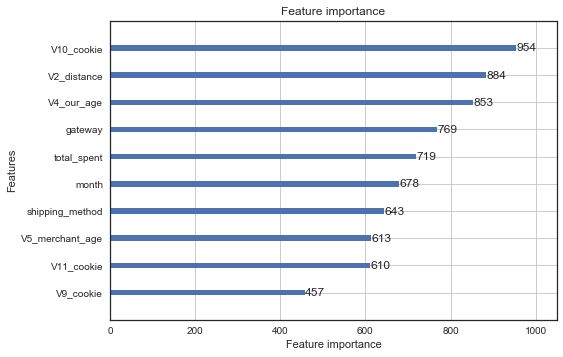

In [605]:
#Plot feature Importances
lgb.plot_importance(lgbm, max_num_features=10, importance_type='split')
plt.show()

### Model Evaluation

<Figure size 576x396 with 0 Axes>

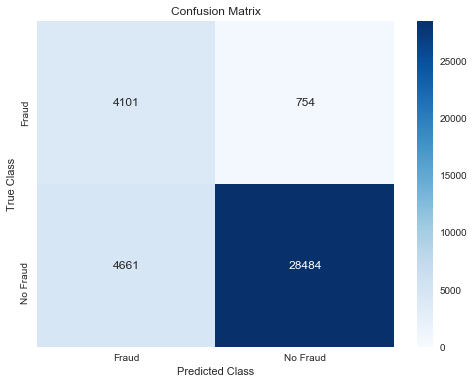

In [606]:
#Print Confusion Matrix
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score

plt.figure()
cm = confusion_matrix(y_test, y_pred)
labels = ['Fraud', 'No Fraud']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

#### Precision , Recall and F1 score

In [607]:
y_prob = pd.DataFrame(y_prob)

In [608]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

In [609]:
# calculate AUC
auc = roc_auc_score(y_test, y_prob)
print('AUC: %.3f' % auc)

AUC: 0.928


In [610]:
print("Recall: {0}".format(round(recall_score(y_test, y_pred),4)))

Recall: 0.8594


In [611]:
print("Precision: {0}".format(round(precision_score(y_test, y_pred),4)))

Precision: 0.9742


In [612]:
# calculate F1 score
f1_score(y_test, y_pred)

0.913197505730728